# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-15 21:40:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [              <=>   ] 201.24M  56.8MB/s    in 3.9s    

2023-10-15 21:40:04 (52.1 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [7]:
set_random_seed(42)

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [9]:
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [10]:
model = Ridge(5).fit(X_train_scale, y_train)
rmse_for_model = mean_squared_error(y_test, model.predict(X_test_scale), squared=False)
rmse_for_model

9.510161273622279

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем:

In [11]:
best_rmse_metric = mean_squared_error(y_test, np.array(y_test.shape[0] * [np.mean(y_train)]), squared=False)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

Создаем модель линейной регрессии с одним Linear слоем

In [12]:
model = nn.Sequential(nn.Linear(X_train.shape[1], 1))
model.to(device)

Sequential(
  (0): Linear(in_features=90, out_features=1, bias=True)
)

Преобразуем данные в тензоры:

In [13]:
X_train_task1 = torch.Tensor(X_train_scale)
X_test_task1 = torch.Tensor(X_test_scale)
y_train_task1 = torch.Tensor(y_train)
y_test_task1 = torch.Tensor(y_test)

Запускаем обучение на 10 эпохах:

In [14]:
epochs = 10

mse_train = []
mse_test = []

for epoch in range(1, epochs + 1):
    y_pred = model(X_train_task1.to(device))
    loss = F.mse_loss(y_pred, y_train_task1.to(device).reshape(-1, 1))
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= 0.13 * param.grad

    model.zero_grad()

    y_pred_test = model(X_test_task1.to(device))
    loss_test = F.mse_loss(y_pred_test, y_test_task1.to(device).reshape(-1, 1))
    
    mse_train.append(loss.item())
    mse_test.append(loss_test.item())
    
    print(
        f"Epoch: {epoch}, loss test: {torch.sqrt(loss_test)}"
    )

Epoch: 1, loss test: 1478.88134765625
Epoch: 2, loss test: 1094.404052734375
Epoch: 3, loss test: 809.9216918945312
Epoch: 4, loss test: 599.3299560546875
Epoch: 5, loss test: 443.6908264160156
Epoch: 6, loss test: 328.2275085449219
Epoch: 7, loss test: 243.49351501464844
Epoch: 8, loss test: 180.189697265625
Epoch: 9, loss test: 136.59521484375
Epoch: 10, loss test: 106.88164520263672


In [15]:
def rmse_to_tensor(y_list):
    return torch.sqrt(torch.Tensor(y_list))

Создадим функцию для отображения MSE и RMSE на train и test:

In [16]:
def plot_metrics(epochs, mse_train, mse_test):
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
    
    axs[0].set_title("Loss function")
    axs[0].plot(range(1, epochs + 1), mse_train, label='MSE train')
    axs[0].plot(range(1, epochs + 1), mse_test, label='MSE test')
    axs[0].set_ylabel("MSE")
    axs[0].set_xlabel("Epochs")
    axs[0].legend()

    axs[1].set_title("Metrics RMSE")
    axs[1].plot(range(1, epochs + 1), rmse_to_tensor(mse_train), label='RMSE train')
    axs[1].plot(range(1, epochs + 1), rmse_to_tensor(mse_test), label='RMSE test')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("RMSE")
    axs[1].legend()
    plt.show()

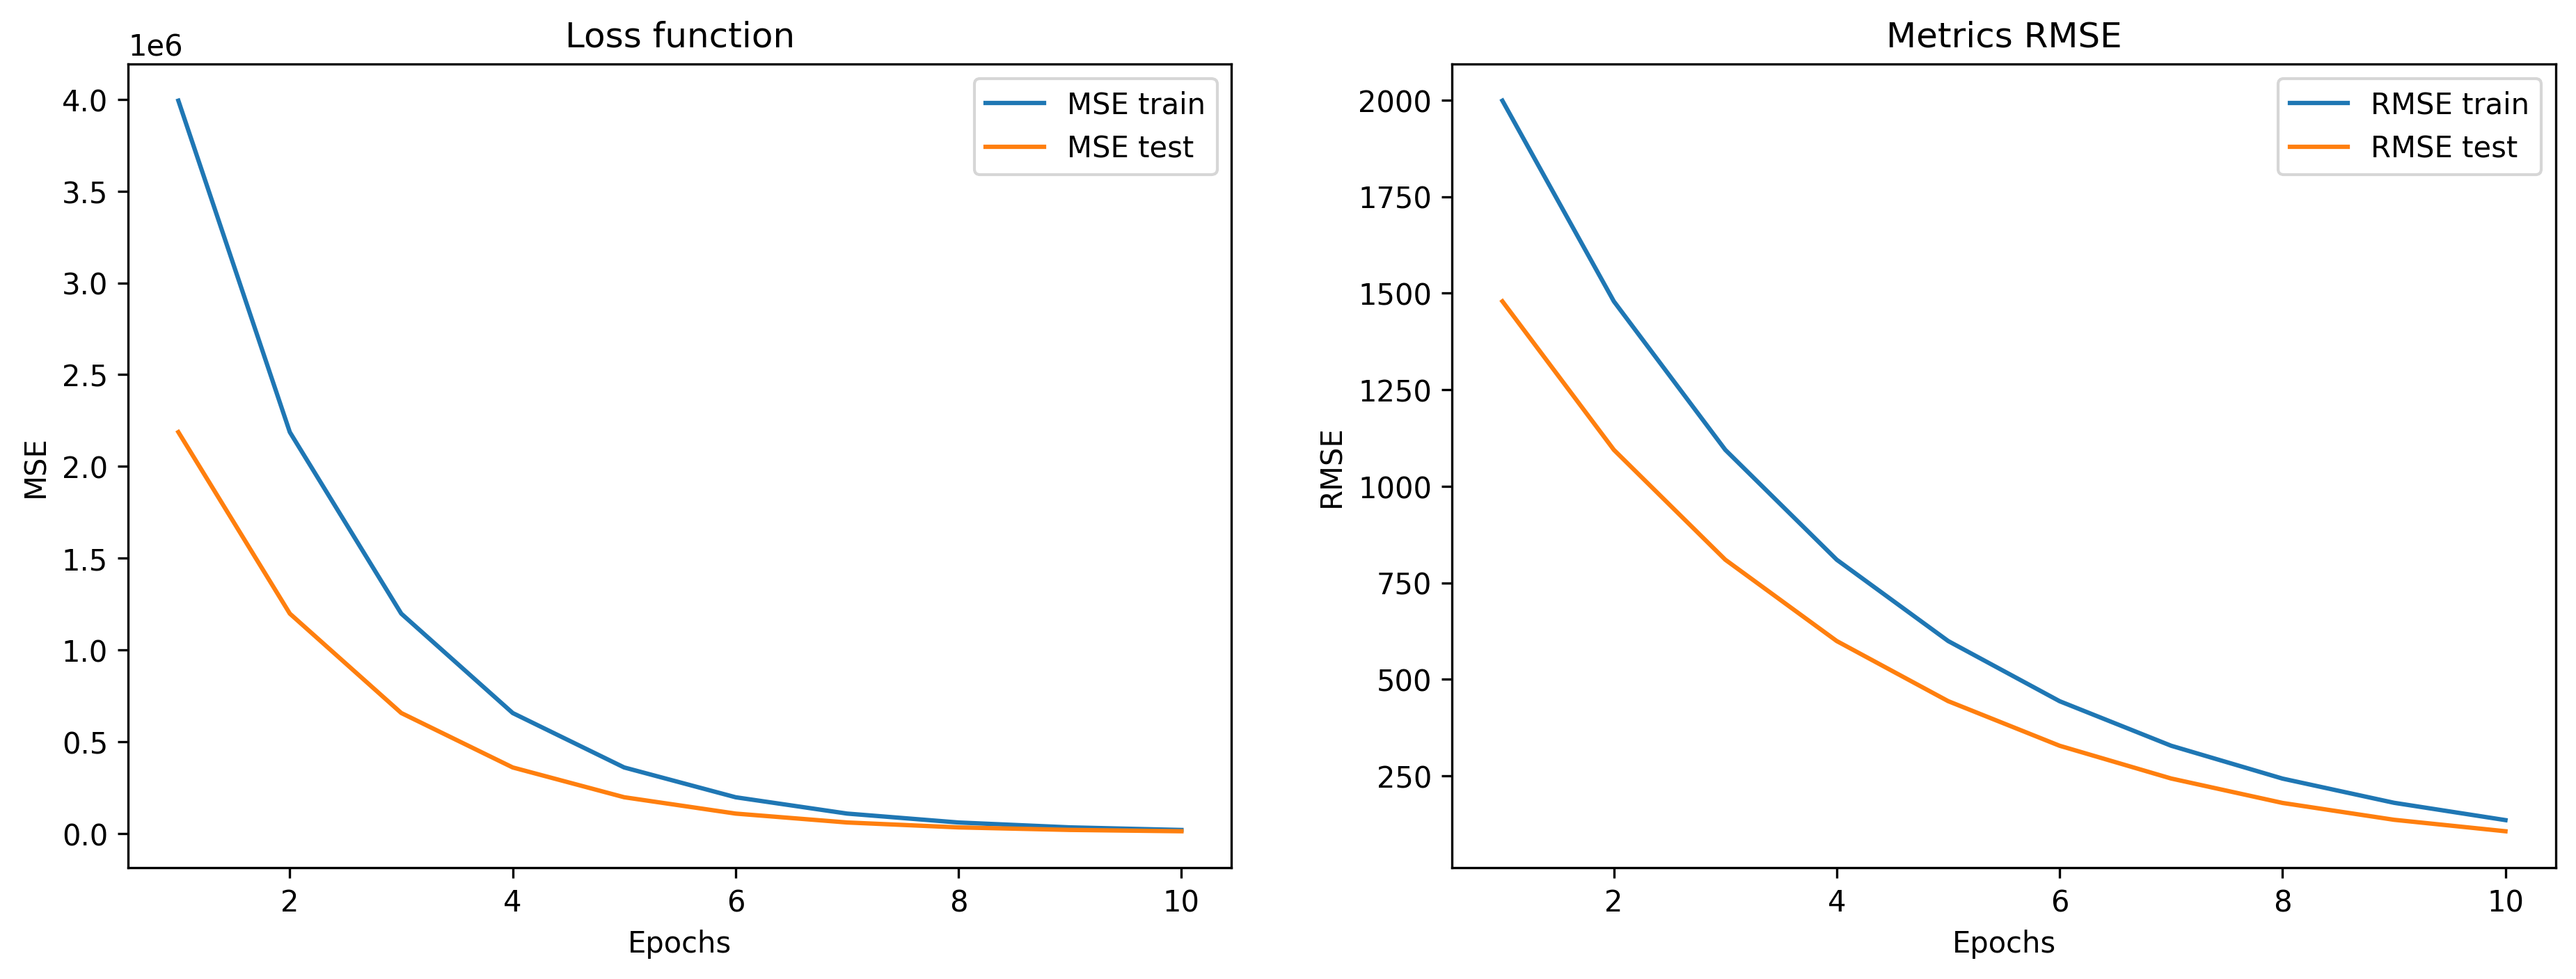

In [17]:
plot_metrics(10, mse_train, mse_test)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

Создадим класс нашего датасета лдя использования в Dataloader:

In [18]:
class SongDataset(torch.utils.data.Dataset):
    """
    Our songs dataset
    """
    
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx, :], self.y[idx])

Реализуем функции `train` и`test`:

In [19]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    for x_train, y_train in tqdm(train_loader):
        y_pred = model(x_train.to(device))
        loss = criterion(y_pred, y_train.to(device))  
        loss.backward()
        optimizer.step()  
        optimizer.zero_grad()  
    
    
def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    predicts = torch.ones(len(test_loader.dataset))
    i = 0
    for x_test, y_test in tqdm(test_loader):
        y_pred = model(x_test.to(device))
        batch_size = test_loader.batch_size
        predicts[i:i + batch_size] = y_pred.squeeze()
        i += batch_size
        
    return predicts

In [20]:
set_random_seed(42)

target_scaler_0 = StandardScaler()
y_train_scaled = target_scaler_0.fit_transform(y_train.reshape(-1, 1))

train_set = SongDataset(X_train_scale, y_train_scaled) 
train_loader_0 = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)  

test_set = SongDataset(X_test_scale, y_test)  
test_loader_0 = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2) 

model_0 = nn.Sequential(
    nn.Linear(X_train.shape[1], 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(64, 1)
)

model_0.to(device)

optimizer_0 = torch.optim.Adagrad(model_0.parameters(), lr=0.01)
criterion = nn.MSELoss()

Проверим правильность работы нашей модели и посмотрим какую метрику она даёт при начальных гиперпараметрах:

In [21]:
for epoch in range(1, 8):

    model_0.train()
    train(model_0, optimizer_0, criterion, train_loader_0, test_loader_0)
    predicts_train = model_0(train_loader_0.dataset.x.to(device))

    model_0.eval()
    with torch.no_grad():
        # скейлим таргет обратно
        predicts_train = predicts_train.cpu().numpy()
        preds_train = torch.Tensor(target_scaler_0.inverse_transform(predicts_train.reshape(-1, 1)))
        
        loss_train = F.mse_loss(preds_train, torch.Tensor(target_scaler_0.inverse_transform(train_loader_0.dataset.y.reshape(-1, 1))))

        predicts_test = test(model_0, criterion, test_loader_0)

        # скейлим таргет обратно
        predicts_test = predicts_test.numpy()
        preds_test = torch.Tensor(target_scaler_0.inverse_transform(predicts_test.reshape(-1, 1)))

        loss_test = F.mse_loss(preds_test, torch.Tensor(test_loader_0.dataset.y.reshape(-1, 1))) 

    print('Epoch: ', epoch, 'loss train: {:.2f}'.format(loss_train.item()), 'RMSE: {:.2f}'.format(torch.sqrt(loss_test).item()))

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch:  1 loss train: 91.12 RMSE: 9.35


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch:  2 loss train: 90.34 RMSE: 9.35


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch:  3 loss train: 89.95 RMSE: 9.31


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch:  4 loss train: 89.72 RMSE: 9.29


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch:  5 loss train: 89.81 RMSE: 9.30


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch:  6 loss train: 89.82 RMSE: 9.27


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch:  7 loss train: 89.94 RMSE: 9.29


In [22]:
assert test(model_0, criterion, test_loader_0).shape[0] == y_test.shape[0]

  0%|          | 0/807 [00:00<?, ?it/s]

В результате нашего эксперимента видим, что ошибка не близка к 8.75. В таком случае будем менять архитектуру нейрнонной сети: будем комибинировать Linear, Dropout и BatchNorm слои. В качестве входов и выходов будем брать степени 2.

Теперь скопируем верхний код архитектуры и будем менять:

In [23]:
def create_model(X_train_scale, X_test_scale, y_train, y_test, device, batch=64, lr=0.01, p=0.3):
    """
    params:
        X_train_scale - X_train scaled
        X_test_scale - X_test scaled
        y_train 
        y_test 
        device - device (cuda)
        batch - current batch size
        lr - learning rate value
        p - Dropout value
    """
    set_random_seed(42)

    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    
    train_set = SongDataset(X_train_scale, y_train_scaled) 
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, num_workers=2)  

    test_set = SongDataset(X_test_scale, y_test)  
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, num_workers=2) 

    model = nn.Sequential(
        nn.BatchNorm1d(X_train.shape[1]),
        nn.Linear(X_train.shape[1], 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(32, 16),
        nn.BatchNorm1d(16),
        nn.ReLU(),
        nn.Linear(16, 1)
    )

    model.to(device)

    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    return train_loader, test_loader, model, optimizer, criterion, target_scaler

In [24]:
def train_test(num_epochs, train_loader, test_loader, model_2, optimizer, criterion, target_scaler):
    mse_train = []
    mse_test = []

    for epoch in range(1, num_epochs + 1):

        model_2.train()
        train(model_2, optimizer, criterion, train_loader, test_loader)
        predicts_train = model_2(train_loader.dataset.x.to(device))
        
        model_2.eval()
        with torch.no_grad():
            # скейлим таргет обратно
            predicts_train = predicts_train.cpu().numpy()
            preds_train = torch.Tensor(target_scaler.inverse_transform(predicts_train.reshape(-1, 1)))
            
            # считаем ошибку на обучающей выборке     
            loss_train = F.mse_loss(preds_train, torch.Tensor(target_scaler.inverse_transform(train_loader.dataset.y.reshape(-1, 1))))

            
            predicts_test = test(model_2, criterion, test_loader)
            
            # скейлим таргет обратно
            predicts_test = predicts_test.numpy()
            preds_test = torch.Tensor(target_scaler.inverse_transform(predicts_test.reshape(-1, 1)))
            
            # считаем ошибку на тестовой выборке  
            loss_test = F.mse_loss(preds_test, torch.Tensor(test_loader.dataset.y.reshape(-1, 1))) 

        mse_train.append(loss_train.item())
        mse_test.append(loss_test.item())


        print('Epoch: ', epoch, 'loss train: {:.2f}'.format(loss_train.item()), 'RMSE: {:.2f}'.format(torch.sqrt(loss_test).item()))
        
    return mse_train, mse_test

Функция для подбора и визуализации гиперпараметров:

In [32]:
def plot_params(array: list, epochs: int, device, X_train, X_test, y_train, y_test):
    mse_train_val = []
    mse_test_val = []
    
    for value in array:
        train_loader, test_loader, model_2, optimizer, criterion, scaler = create_model(X_train, X_test, y_train, y_test, device, batch=value) #lr=value, p=value, batch=value
        mse_train_val, mse_test_val = train_test(epochs, train_loader, test_loader,model_2, optimizer, criterion, scaler)
        plt.plot(range(1, epochs + 1), rmse_to_tensor(mse_test_val), label=f'parametr = {value}')
        
    plt.legend()

Подбёрем на части выборки learning rate и архитектуру для нашей модели, используя функцию для подбора параметров `plot_params` со значением `lr=value`:

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  1 loss train: 96.53 RMSE: 10.34


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  2 loss train: 91.42 RMSE: 10.01


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  3 loss train: 88.34 RMSE: 9.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  4 loss train: 86.76 RMSE: 9.87


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  5 loss train: 83.60 RMSE: 9.75


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  6 loss train: 82.51 RMSE: 9.74


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  7 loss train: 81.34 RMSE: 9.66


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  8 loss train: 80.49 RMSE: 9.68


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  9 loss train: 79.47 RMSE: 9.66


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  10 loss train: 78.29 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  11 loss train: 77.97 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  12 loss train: 77.70 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  13 loss train: 76.56 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  14 loss train: 76.21 RMSE: 9.64


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  15 loss train: 76.12 RMSE: 9.62


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  16 loss train: 75.53 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  17 loss train: 75.44 RMSE: 9.65


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  18 loss train: 75.41 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  19 loss train: 73.65 RMSE: 9.68


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  20 loss train: 73.90 RMSE: 9.69


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  21 loss train: 73.44 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  22 loss train: 73.36 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  23 loss train: 73.10 RMSE: 9.66


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  24 loss train: 73.69 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  25 loss train: 72.21 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  26 loss train: 72.99 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  27 loss train: 71.81 RMSE: 9.78


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  28 loss train: 72.01 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  29 loss train: 72.38 RMSE: 9.75


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  30 loss train: 71.27 RMSE: 9.77


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  1 loss train: 92.43 RMSE: 10.26


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  2 loss train: 87.65 RMSE: 10.08


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  3 loss train: 84.14 RMSE: 9.83


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  4 loss train: 82.38 RMSE: 9.85


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  5 loss train: 81.04 RMSE: 9.79


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  6 loss train: 79.71 RMSE: 9.81


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  7 loss train: 78.60 RMSE: 9.76


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  8 loss train: 76.25 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  9 loss train: 75.62 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  10 loss train: 75.07 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  11 loss train: 74.30 RMSE: 9.81


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  12 loss train: 73.26 RMSE: 9.78


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  13 loss train: 73.05 RMSE: 9.80


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  14 loss train: 72.85 RMSE: 9.96


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  15 loss train: 72.09 RMSE: 9.98


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  16 loss train: 71.80 RMSE: 9.93


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  17 loss train: 71.93 RMSE: 9.93


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  18 loss train: 71.03 RMSE: 9.93


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  19 loss train: 71.35 RMSE: 9.99


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  20 loss train: 70.55 RMSE: 9.90


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  21 loss train: 71.14 RMSE: 9.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  22 loss train: 70.80 RMSE: 10.08


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  23 loss train: 72.95 RMSE: 10.07


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  24 loss train: 71.03 RMSE: 10.16


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  25 loss train: 70.66 RMSE: 9.97


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  26 loss train: 71.26 RMSE: 10.20


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  27 loss train: 73.13 RMSE: 10.12


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  28 loss train: 73.28 RMSE: 10.15


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  29 loss train: 72.49 RMSE: 10.33


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  30 loss train: 71.34 RMSE: 10.26


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  1 loss train: 94.42 RMSE: 10.25


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  2 loss train: 87.73 RMSE: 9.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  3 loss train: 84.28 RMSE: 9.85


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  4 loss train: 82.68 RMSE: 9.80


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  5 loss train: 81.03 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  6 loss train: 80.39 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  7 loss train: 78.06 RMSE: 9.66


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  8 loss train: 77.79 RMSE: 9.69


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  9 loss train: 76.47 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  10 loss train: 76.22 RMSE: 9.68


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  11 loss train: 74.39 RMSE: 9.72


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  12 loss train: 75.39 RMSE: 9.86


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  13 loss train: 74.94 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  14 loss train: 73.55 RMSE: 9.75


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  15 loss train: 72.96 RMSE: 9.79


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  16 loss train: 74.75 RMSE: 10.02


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  17 loss train: 74.95 RMSE: 9.83


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  18 loss train: 73.59 RMSE: 9.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  19 loss train: 75.89 RMSE: 9.99


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  20 loss train: 75.10 RMSE: 9.96


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  21 loss train: 77.56 RMSE: 9.96


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  22 loss train: 77.32 RMSE: 10.01


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  23 loss train: 76.18 RMSE: 10.15


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  24 loss train: 78.69 RMSE: 10.01


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  25 loss train: 75.34 RMSE: 10.07


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  26 loss train: 84.44 RMSE: 9.99


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  27 loss train: 78.07 RMSE: 10.07


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  28 loss train: 78.21 RMSE: 10.04


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  29 loss train: 79.15 RMSE: 10.06


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  30 loss train: 81.35 RMSE: 10.09


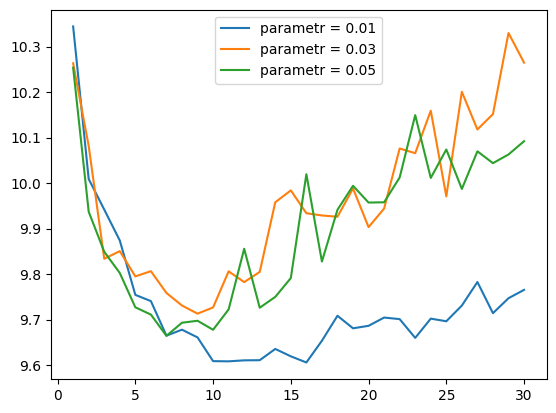

In [27]:
plot_params([0.01, 0.03, 0.05], 30, device, X_train_scale[:10000], X_test_scale[:10000], y_train[:10000], y_test[:10000])

Видим, что наименьшая метрика у `learning rate = 0.01`. Значит его и будем использовать в нашей модели 

Сейчас подберём параметр probability, для этого надо будет менять функцию `plot_param` - в `create_model()` присваивать `value` необходимому параметру `p` - `p=value`:

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  1 loss train: 90.33 RMSE: 10.20


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  2 loss train: 83.78 RMSE: 9.85


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  3 loss train: 79.80 RMSE: 9.78


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  4 loss train: 77.18 RMSE: 9.78


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  5 loss train: 74.80 RMSE: 9.80


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  6 loss train: 72.74 RMSE: 9.89


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  7 loss train: 70.66 RMSE: 9.85


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  8 loss train: 69.47 RMSE: 9.98


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  9 loss train: 68.47 RMSE: 10.08


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  10 loss train: 66.16 RMSE: 10.01


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  11 loss train: 67.77 RMSE: 10.08


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  12 loss train: 65.92 RMSE: 10.05


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  13 loss train: 66.67 RMSE: 10.19


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  14 loss train: 65.53 RMSE: 10.12


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  15 loss train: 66.54 RMSE: 10.16


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  16 loss train: 65.71 RMSE: 10.15


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  17 loss train: 64.14 RMSE: 10.21


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  18 loss train: 65.37 RMSE: 10.35


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  19 loss train: 66.30 RMSE: 10.33


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  20 loss train: 64.21 RMSE: 10.24


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  21 loss train: 66.24 RMSE: 10.33


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  22 loss train: 65.10 RMSE: 10.27


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  23 loss train: 63.93 RMSE: 10.23


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  24 loss train: 65.38 RMSE: 10.16


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  25 loss train: 63.22 RMSE: 10.24


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  26 loss train: 64.80 RMSE: 10.25


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  27 loss train: 64.01 RMSE: 10.26


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  28 loss train: 64.72 RMSE: 10.24


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  29 loss train: 64.95 RMSE: 10.24


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  30 loss train: 65.18 RMSE: 10.22


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  1 loss train: 96.53 RMSE: 10.34


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  2 loss train: 91.42 RMSE: 10.01


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  3 loss train: 88.34 RMSE: 9.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  4 loss train: 86.76 RMSE: 9.87


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  5 loss train: 83.60 RMSE: 9.75


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  6 loss train: 82.51 RMSE: 9.74


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  7 loss train: 81.34 RMSE: 9.66


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  8 loss train: 80.49 RMSE: 9.68


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  9 loss train: 79.47 RMSE: 9.66


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  10 loss train: 78.29 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  11 loss train: 77.97 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  12 loss train: 77.70 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  13 loss train: 76.56 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  14 loss train: 76.21 RMSE: 9.64


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  15 loss train: 76.12 RMSE: 9.62


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  16 loss train: 75.53 RMSE: 9.61


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  17 loss train: 75.44 RMSE: 9.65


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  18 loss train: 75.41 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  19 loss train: 73.65 RMSE: 9.68


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  20 loss train: 73.90 RMSE: 9.69


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  21 loss train: 73.44 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  22 loss train: 73.36 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  23 loss train: 73.10 RMSE: 9.66


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  24 loss train: 73.69 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  25 loss train: 72.21 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  26 loss train: 72.99 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  27 loss train: 71.81 RMSE: 9.78


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  28 loss train: 72.01 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  29 loss train: 72.38 RMSE: 9.75


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  30 loss train: 71.27 RMSE: 9.77


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  1 loss train: 101.82 RMSE: 10.65


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  2 loss train: 99.61 RMSE: 10.52


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  3 loss train: 98.37 RMSE: 10.46


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  4 loss train: 96.53 RMSE: 10.36


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  5 loss train: 94.39 RMSE: 10.28


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  6 loss train: 93.17 RMSE: 10.19


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  7 loss train: 92.02 RMSE: 10.12


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  8 loss train: 90.09 RMSE: 10.04


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  9 loss train: 89.45 RMSE: 10.01


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  10 loss train: 88.42 RMSE: 9.96


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  11 loss train: 87.92 RMSE: 9.95


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  12 loss train: 87.66 RMSE: 9.90


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  13 loss train: 86.74 RMSE: 9.88


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  14 loss train: 85.41 RMSE: 9.87


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  15 loss train: 85.38 RMSE: 9.87


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  16 loss train: 84.96 RMSE: 9.82


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  17 loss train: 84.35 RMSE: 9.81


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  18 loss train: 83.65 RMSE: 9.82


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  19 loss train: 83.79 RMSE: 9.75


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  20 loss train: 83.32 RMSE: 9.76


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  21 loss train: 83.18 RMSE: 9.76


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  22 loss train: 82.28 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  23 loss train: 83.37 RMSE: 9.75


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  24 loss train: 82.22 RMSE: 9.74


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  25 loss train: 81.76 RMSE: 9.73


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  26 loss train: 81.81 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  27 loss train: 81.98 RMSE: 9.71


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  28 loss train: 81.87 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  29 loss train: 81.43 RMSE: 9.70


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:  30 loss train: 81.03 RMSE: 9.69


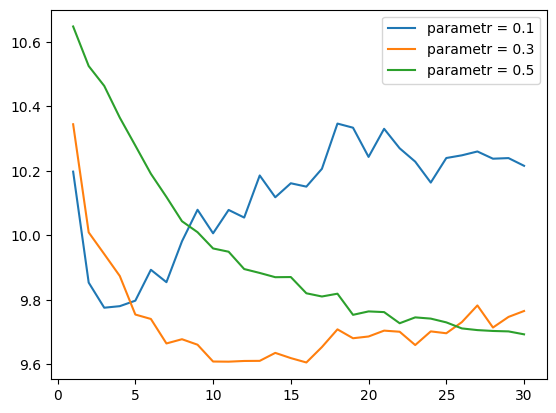

In [30]:
plot_params([0.1, 0.3, 0.5], 30, device, X_train_scale[:10000], X_test_scale[:10000], y_train[:10000], y_test[:10000])

Видим, что для `p = 0.5` график идёт монотонно вниз к 30 эпохам, поэтому возьмём это значение в качестве гиперпараметра.

По подобранным гиперпараметрам `batch size = 2048` и `learning rate=0.01` и`p = 0.5` будем смотреть на метрики нашей нейронной сети на 40 эпохах:

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  1 loss train: 84.10 RMSE: 9.04


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  2 loss train: 81.96 RMSE: 8.96


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  3 loss train: 80.92 RMSE: 8.92


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  4 loss train: 80.26 RMSE: 8.90


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  5 loss train: 79.74 RMSE: 8.88


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  6 loss train: 79.21 RMSE: 8.86


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  7 loss train: 79.03 RMSE: 8.85


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  8 loss train: 78.65 RMSE: 8.84


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  9 loss train: 78.45 RMSE: 8.83


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  10 loss train: 78.27 RMSE: 8.82


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  11 loss train: 78.09 RMSE: 8.82


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  12 loss train: 77.87 RMSE: 8.81


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  13 loss train: 77.79 RMSE: 8.81


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  14 loss train: 77.47 RMSE: 8.80


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  15 loss train: 77.49 RMSE: 8.80


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  16 loss train: 77.33 RMSE: 8.80


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  17 loss train: 77.15 RMSE: 8.79


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  18 loss train: 77.16 RMSE: 8.79


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  19 loss train: 76.94 RMSE: 8.79


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  20 loss train: 76.98 RMSE: 8.78


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  21 loss train: 76.72 RMSE: 8.78


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  22 loss train: 76.77 RMSE: 8.78


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  23 loss train: 76.67 RMSE: 8.77


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  24 loss train: 76.57 RMSE: 8.77


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  25 loss train: 76.52 RMSE: 8.77


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  26 loss train: 76.44 RMSE: 8.76


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  27 loss train: 76.33 RMSE: 8.76


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  28 loss train: 76.15 RMSE: 8.76


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  29 loss train: 76.10 RMSE: 8.76


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  30 loss train: 76.06 RMSE: 8.76


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  31 loss train: 75.97 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  32 loss train: 76.04 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  33 loss train: 76.02 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  34 loss train: 75.83 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  35 loss train: 75.83 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  36 loss train: 75.77 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  37 loss train: 75.60 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  38 loss train: 75.64 RMSE: 8.75


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  39 loss train: 75.50 RMSE: 8.74


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch:  40 loss train: 75.52 RMSE: 8.74


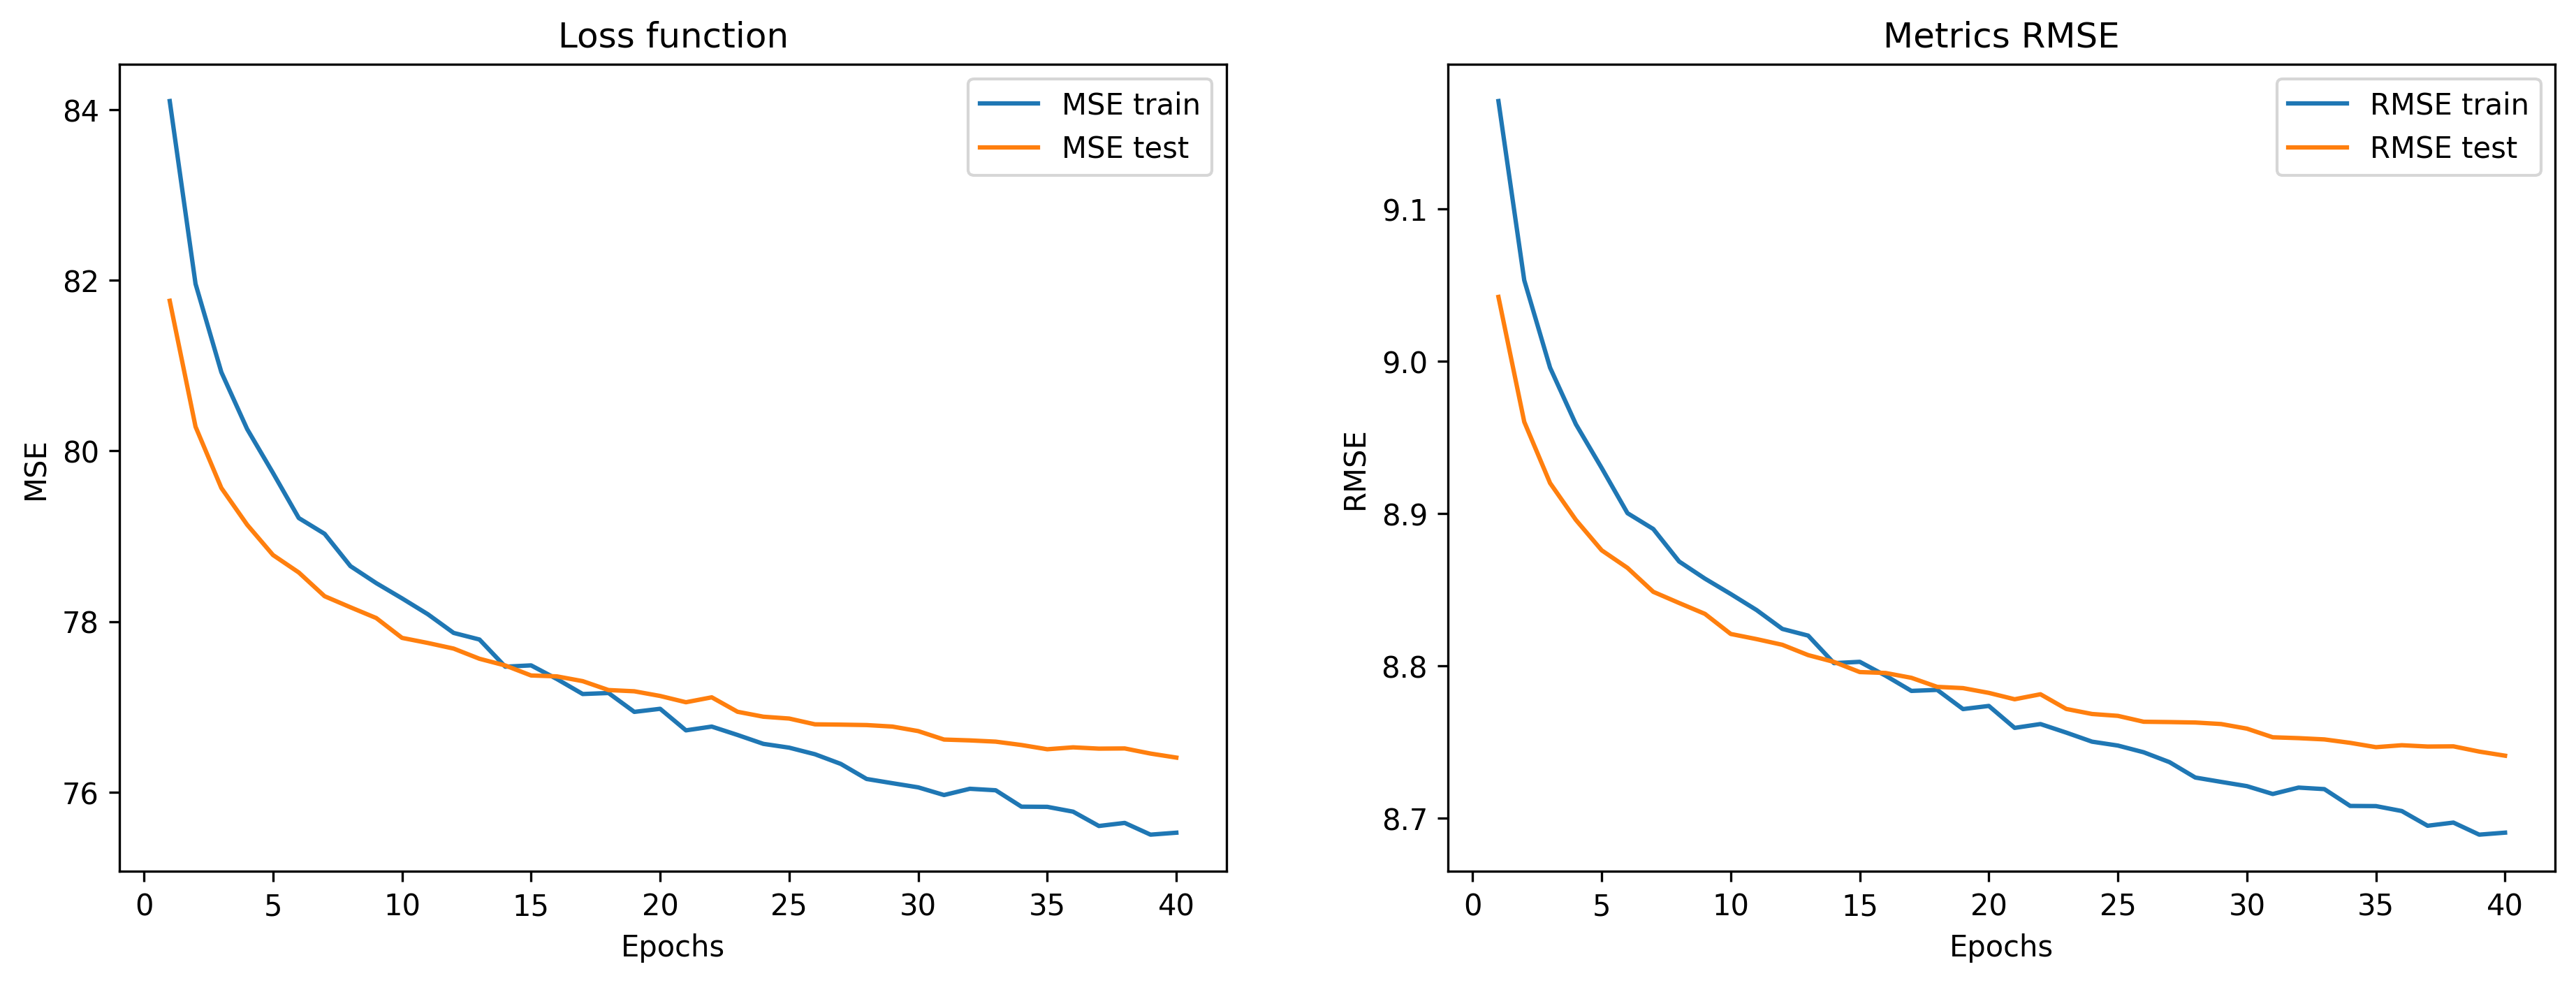

In [31]:
epochs = 40

train_val = []
test_val = []

train_loader_val, test_loader_val, model_optim, optimizer_val, criterion, scaler_val = create_model(X_train_scale, X_test_scale, y_train, y_test, device, 2048, 0.01, 0.5)
train_val, test_val = train_test(epochs, train_loader_val, test_loader_val, model_optim, optimizer_val, criterion, scaler_val)

plot_metrics(epochs, train_val, test_val)

#### Получаем, что при подобранных гиперпараметрах наша метрика `RMSE = 8.74`.

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Первым делом необходимо было понять примерную архитектуру модели. Так как нам на лекции говорили, что чаще всего BatchNorm используют в начале, а Droput - в конце, то я решила создать несколько "слоёв", которые будут иметь следующий вид: BatchNorm -> Linear -> ReLU -> Dropout. Поискав на просторах интернета, я нашла что BatchNorm лучше использовать до нелинейности, а Dropout - после.

Количество входов и выходов в полносвязные слои я решила брать за степени двойки, так как компьютеру удобнее справляться с этими числами. В качестве первого эксперимента я построила нейросеть с такой моделью (см. выше) и протестировала её на выборке. Выявилось, что первый вариант архитектуры не подходит, и уже далее, в функцию `create_model()` я добавляла "слои" и подбирала гиперпараметры.

Далее для получения необходимого качества я подбирала гиперпараметры: batch size, learning rate и probability, который находится в Dropout. Эксперименты с learning rate и probability приведены выше в ходе создания архитектуры модели.



Для подобра размера батча надо будет менять функцию `plot_param` - в `create_model()` присваивать `value` необходимому параметру `batch` - `batch=value`. Гиперпараметр `batch size = 2048`, так как самый маленькая ошибка получается при таком значении. 

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  1 loss train: 87.93 RMSE: 10.11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  2 loss train: 79.91 RMSE: 9.62


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  3 loss train: 75.89 RMSE: 9.44


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  4 loss train: 72.81 RMSE: 9.40


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  5 loss train: 70.72 RMSE: 9.38


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  6 loss train: 69.06 RMSE: 9.33


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  7 loss train: 67.72 RMSE: 9.39


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  8 loss train: 65.85 RMSE: 9.34


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  9 loss train: 64.90 RMSE: 9.36


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  10 loss train: 63.06 RMSE: 9.35


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1 loss train: 89.24 RMSE: 10.50


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  2 loss train: 80.92 RMSE: 9.83


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  3 loss train: 76.27 RMSE: 9.48


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  4 loss train: 73.49 RMSE: 9.43


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  5 loss train: 71.22 RMSE: 9.40


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  6 loss train: 68.35 RMSE: 9.36


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  7 loss train: 67.09 RMSE: 9.46


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  8 loss train: 65.94 RMSE: 9.41


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  9 loss train: 62.99 RMSE: 9.29


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  10 loss train: 62.57 RMSE: 9.39


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1 loss train: 93.71 RMSE: 10.70


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  2 loss train: 84.24 RMSE: 10.24


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  3 loss train: 78.56 RMSE: 9.76


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  4 loss train: 75.22 RMSE: 9.47


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  5 loss train: 72.15 RMSE: 9.40


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  6 loss train: 69.27 RMSE: 9.31


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  7 loss train: 68.55 RMSE: 9.28


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  8 loss train: 65.69 RMSE: 9.25


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  9 loss train: 64.55 RMSE: 9.31


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  10 loss train: 63.54 RMSE: 9.30


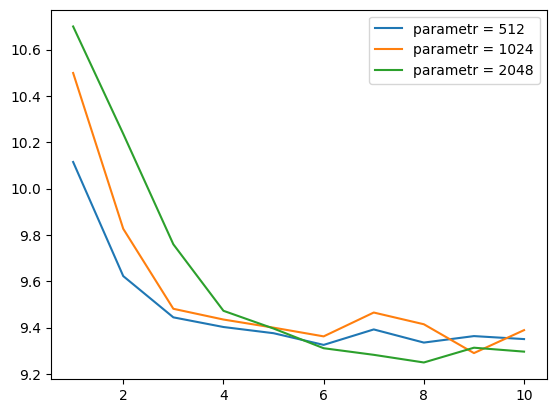

In [33]:
plot_params([512, 1024, 2048], 10, device, X_train_scale[:10000], X_test_scale[:10000], y_train[:10000], y_test[:10000]) 